In [1]:
import os
from ultralytics import YOLO
import torchvision
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from xai.drise_batch import DRISEBatch
from utils.utils import load_and_convert_bboxes
from utils.plot_utils import plot_image_with_bboxes, plot_saliency_and_targetbb_on_image

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = Args(**{
    'img_name': '00901',
    'model_path': 'use_case/models/best.pt',
    'datadir': 'use_case/',
    'annotations_dir': 'use_case/',
    'device': 'cuda:0',
    'input_size': (480, 640),
    'gpu_batch': 16,
    'mask_type': 'rise',
    'maskdir': 'masks/',
    'N': 1000,
    'resolution': 8,
    'p1': 0.5,
    'target_classes': [0],
})

## Data Processing

(480, 640, 3)
(480, 640, 3) uint8


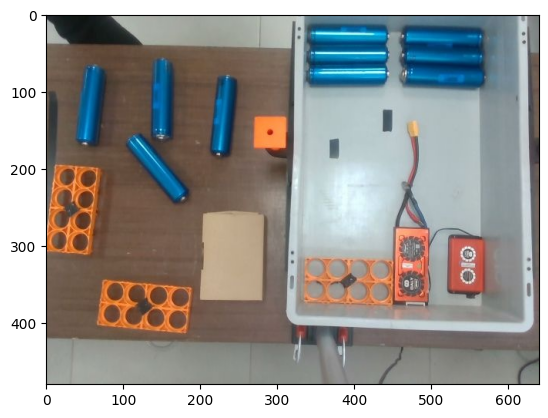

In [3]:
#########################
# Import data
#########################
height, width = args.input_size
img_path = args.datadir + args.img_name
orig_img = Image.open(img_path + '.jpg')
resized_img = orig_img.resize((width, height), Image.LANCZOS)
img_np = np.array(resized_img)

plt.imshow(img_np)
print(img_np.shape)
print(img_np.shape, img_np.dtype)

# preprocessing function
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

tensor = preprocess(img_np)
tensor = tensor.unsqueeze(0).to(args.device) # 1,3,224,224

Labels directory: use_case/00901.txt


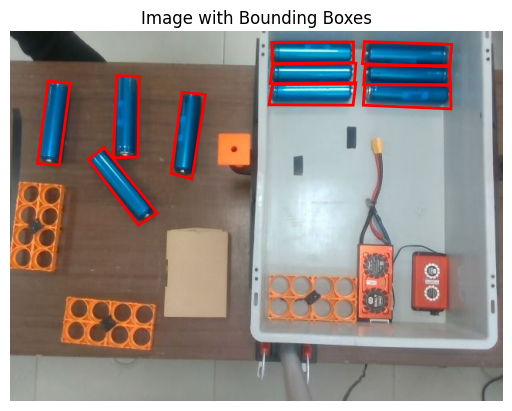

In [4]:
from datetime import datetime


labels = args.annotations_dir + args.img_name + '.txt'
print('Labels directory:', labels)

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

for tc in [0]:#[0,1,2,3,4,5,6,7]:
    bboxes, _ = load_and_convert_bboxes(labels,img_height=args.input_size[0],img_width=args.input_size[1], target_class= tc)
    plot_image_with_bboxes(img_np,bboxes, save_to=f'output/{args.img_name}_bboxes_class{tc}_{date_time}.png')

### set the target class

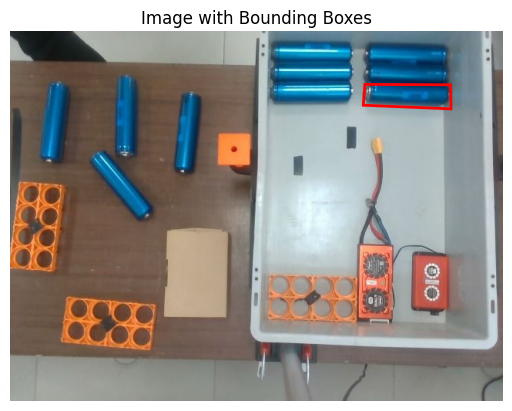

Target bbox: [(460.41984, 68.31984), (571.68, 68.84976), (572.20992, 100.11024), (458.30016, 95.34)]


In [5]:
target_class = args.target_classes[0] # select a single class (list is given)
bboxes, _ = load_and_convert_bboxes(labels,img_height=args.input_size[0],img_width=args.input_size[1], target_class= target_class)
target_bbox = bboxes[0] # select the first bbox --> multiple might be given in the same image
plot_image_with_bboxes(img_np,[target_bbox], save_to=f'output/{args.img_name}_target_bbox_class{target_class}_{date_time}.png')
print('Target bbox:',target_bbox)

## YOLO
Load model and test to see its predictions

In [6]:
model = YOLO(args.model_path, task='detect')


0: 480x640 10 battery_individuals, 1 bms_a, 1 bms_b, 1 unknown_object, 3 battery_holders, 52.9ms
Speed: 0.4ms preprocess, 52.9ms inference, 77.2ms postprocess per image at shape (1, 3, 480, 640)


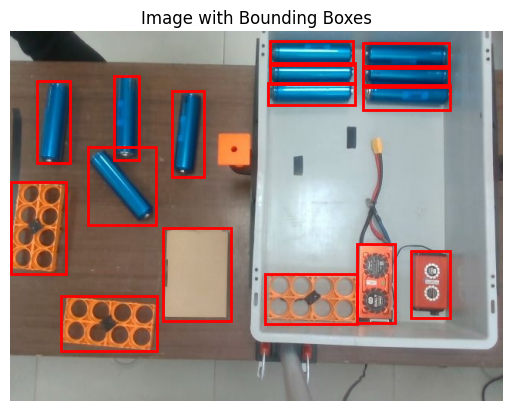

In [7]:
results=model.predict(tensor) 

boxes = results[0].boxes  # Assuming we have one image and accessing the first result
predicted_bboxes = []
for box in boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
    # Convert to a list of (x, y) tuples
    bbox = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    predicted_bboxes.append(bbox)
# print(bboxes)
image_with_bboxes = plot_image_with_bboxes(img_np, predicted_bboxes, save_to=f'output/{args.img_name}_predicted_bboxes_{date_time}.png')

## D-RISE

### Generate masks

In [8]:
explainer = DRISEBatch(
    model=model, 
    input_size=args.input_size, 
    device=args.device,
    gpu_batch=args.gpu_batch
)

# if generate or load
generate_new = True

mask_filename = f'{args.mask_type}_n{args.N}_s{args.resolution}_p{args.p1}_{args.input_size[0]}x{args.input_size[1]}'
mask_path = args.maskdir + mask_filename + '.npy'
print(mask_path)

if generate_new or not os.path.isfile(mask_path):
    explainer.generate_masks_rise(N=args.N, s=args.resolution, p1=args.p1, savepath= mask_path)
else:
    explainer.load_masks(mask_path)
    print('Masks are loaded.')

masks/rise_n1000_s8_p0.5_480x640.npy
Cell size: [         60          80]
Grid shape: (1000, 8, 8)


Generating filters: 100%|██████████| 1000/1000 [00:07<00:00, 133.70it/s]


Total time: 7.48seg


Visualize 3 generated masks

(3, 3, 480, 640)


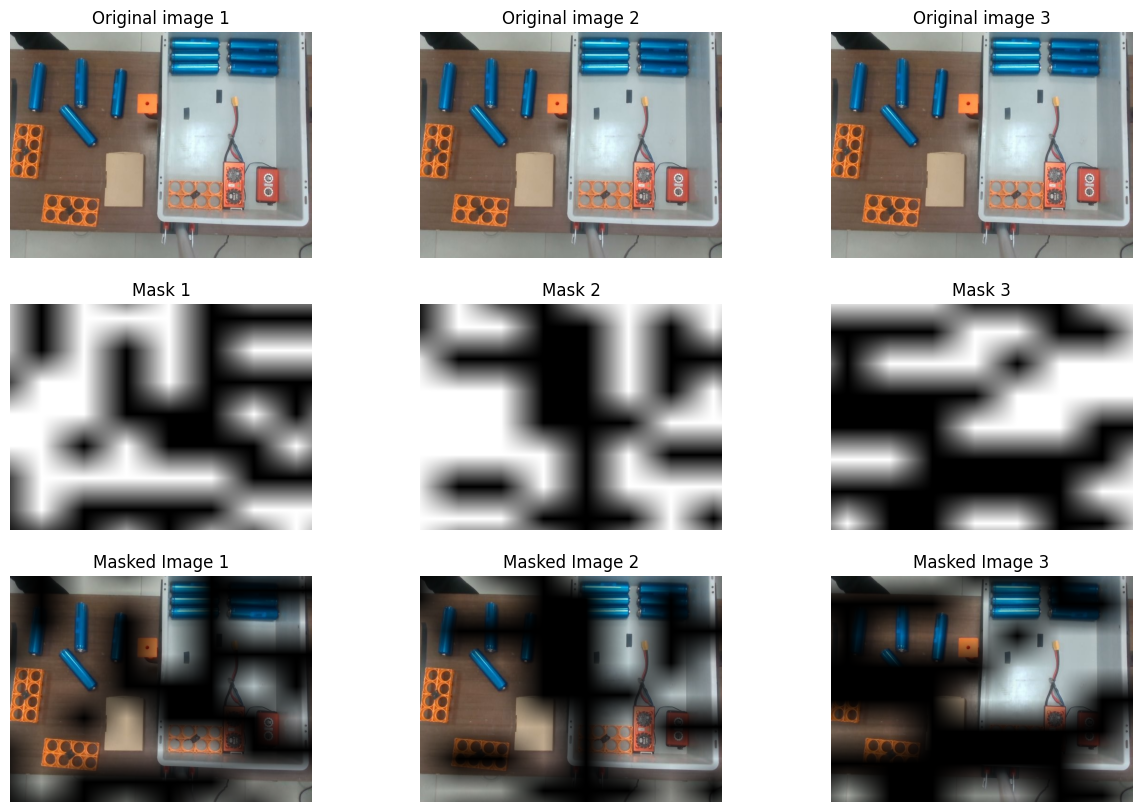

In [9]:
num_masks=3
masks = explainer.masks[:3]

masked_image = torch.mul(masks.to(args.device), tensor)
masked_image = masked_image.cpu().numpy()
print(masked_image.shape)

masks = masks.cpu()
if masks.ndim == 4:  # If the masks have a shape of (N, 1, H, W)
    masks = masks[:, 0, :, :]

fig, axes = plt.subplots(3, num_masks, figsize=(15, 10))

for i, ax in enumerate(axes[0]):
    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title(f'Original image {i + 1}')

for i, ax in enumerate(axes[1]):
    ax.imshow(masks[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Mask {i + 1}')

for i, ax in enumerate(axes[2]):
    ax.imshow(masked_image[i].transpose(1, 2, 0))
    ax.axis('off')
    ax.set_title(f'Masked Image {i + 1}')
    
plt.show()

### Apply XAI

In [10]:
# print(tensor.permute(0,1,3,2).shape)
saliency = explainer(
    x=tensor,
    target_class_indices=args.target_classes,
    target_bbox=target_bbox
)

100%|██████████| 63/63 [00:07<00:00,  8.56it/s]


### Plot heatmap/saliency map given by XAI

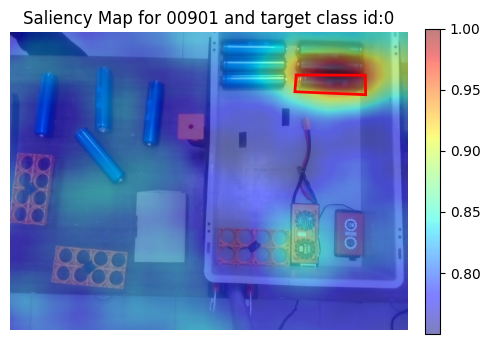

In [11]:
plot_saliency_and_targetbb_on_image(
        height=args.input_size[0], width=args.input_size[1], 
        img_name=args.img_name, 
        img=img_np,
        saliency_map=saliency[target_class], 
        target_class_id= target_class,
        target_bbox=target_bbox,
        save_to=f'output/{args.img_name}_saliency_targetbb_class{target_class}_{date_time}.png'
    )

## do the same for another target bbox

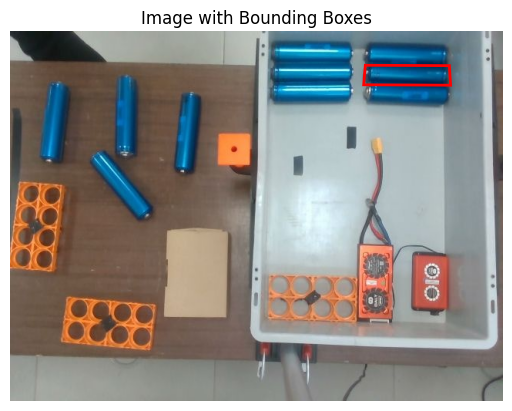

Target bbox: [(460.94976, 43.47), (570.09024, 43.95), (571.68, 69.38016), (458.83007999999995, 68.84976)]


In [12]:
bboxes, _ = load_and_convert_bboxes(labels,img_height=args.input_size[0],img_width=args.input_size[1], target_class= target_class)
target_bbox = bboxes[1] # select the first bbox --> multiple might be given in the same image
plot_image_with_bboxes(img_np,[target_bbox])
print('Target bbox:',target_bbox)

In [13]:
saliency = explainer(x=tensor,
                     target_class_indices=[target_class],
                     target_bbox=target_bbox)

100%|██████████| 63/63 [00:07<00:00,  8.26it/s]


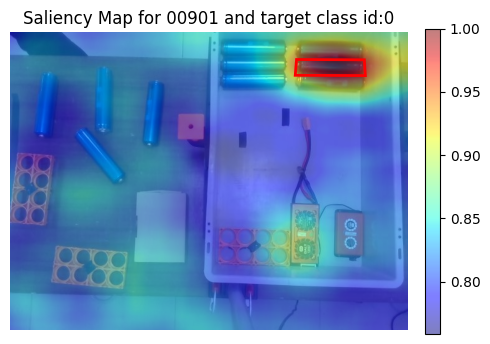

In [14]:
image_with_bbox_and_saliency = plot_saliency_and_targetbb_on_image(
        height=args.input_size[0], width=args.input_size[1], 
        img_name=args.img_name, 
        img=img_np,
        saliency_map=saliency[target_class], 
        target_class_id= target_class,
        target_bbox=target_bbox
    )

## LLAMA VL

In [15]:
import os, re
from unsloth import FastVisionModel # FastLanguageModel for LLMs

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)


c:\Users\Linda\Documents\PALocalDev\drise_dmfpp_ddeletion\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu126 for torchao version 0.14.0         Please see GitHub issue #2919 for more info
W1019 16:40:51.809284 15516 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.3: Fast Mllama patching. Transformers: 4.56.1.
   \\   /|    NVIDIA GeForce RTX 4070. Num GPUs = 1. Max memory: 11.994 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!


from PIL import Image
import requests
from io import BytesIO


# what images to send to llama: 
# orig. image
resized_img
#yolo detected bboxes

yoloPredictedBboxes = Image.open(f'output/{args.img_name}_predicted_bboxes_{date_time}.png')

# saliency map with target bbox

driseSaliency = Image.open(f'output/{args.img_name}_saliency_targetbb_class{target_class}_{date_time}.png')


images = [resized_img, yoloPredictedBboxes, driseSaliency]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

composed = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
  composed.paste(im, (x_offset,0))
  x_offset += im.size[0]

composed.save(f'output/composedImage{target_class}_{date_time}.jpg')

# url = "https://s7ap1.scene7.com/is/image/destqueensland/teq/consumer/global/images/destinations/sunshine-coast/blog-images/editorial-hero-banner/2018_SC_Koala_Wildlife_Australiazoo.jpg?bfc=on&fit=wrap&fmt=webp&qlt=100&resMode=bisharp&wid=1200"

# response = requests.get(url)
# image = Image.open(BytesIO(response.content))

instruction = """You are the Visual LLM specializing in detailed explanation chaining for Visual-LLMs. 
When provided with an image that includes an object, its corresponding bounding box, and a saliency map, your task is to deliver a comprehensive and in-depth analysis of the selected areas within the bounding box. 

Focus on unpacking the rationale behind the model's attention to these highlighted regions. Your response should encompass an extensive discussion on several key features influencing the model's decisions, including but not limited to:

- **Color:** Analyze how the colors present may hold significance in drawing model attention.
- **Texture:** Discuss the textural elements and how they contribute to the understanding of the object and its environment.
- **Shape:** Examine the geometric attributes of the object and how they interact with the bounding box.
- **Context:** Consider the contextual elements of the image that may provide additional meaning or relevance to the selected focal areas.

Your explanation should aim for clarity, depth, and informativeness, ensuring that every aspect of the analysis is well-articulated and beneficial for the user's understanding.
"""

# print(type(resized_img), type(yoloPredictedBboxes), type(driseSaliency))

# # Process images properly
# image_inputs = [resized_img, yoloPredictedBboxes, driseSaliency]

# image_inputs = [img.convert("RGB").resize((224,224)) for img in image_inputs]

# for img in image_inputs:
#     print(img, img.size)

# # Concatenate images horizontally
# total_width = sum(img.width for img in image_inputs)
# max_height = max(img.height for img in image_inputs)

# composed = Image.new("RGB", (total_width, max_height))
# x_offset = 0


# for img in image_inputs:
#     composed.paste(img, (x_offset, 0))
#     x_offset += img.width



messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    composed,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 400,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

**Comprehensive Analysis of Bounding Box and Saliency Map for Visual LLM**

**Color Analysis**

The color of the objects within the bounding box may significantly influence the model's attention. The bright blue color of the battery cells and the orange of the battery cases and other objects likely draw the model's focus to these areas. The model's ability to distinguish and emphasize these colors may indicate its focus on these parts for analysis and understanding. Additionally, the warm colors may have more weight in the saliency map, indicating the importance of these colors in the model's decision-making process.

**Texture Analysis**

The texture of the battery
